In [ ]:
!unzip /content/self-driving-car-master.zip

In [4]:
# Importing all necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

In [5]:
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

In [6]:
import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [7]:
# The dataset has 6 columns — center, left, right, steering, throttle, reverse, speed (values)
# I have used pandas dataframe to display the first five rows in the dataset

columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(("/content/self-driving-car-master/driving_log.csv"), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

FileNotFoundError: ignored

In [ ]:
# Removed the prefix part throughout the dataset

def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_07_22_20_38_15_382.jpg,left_2019_07_22_20_38_15_382.jpg,right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,center_2019_07_22_20_38_15_526.jpg,left_2019_07_22_20_38_15_526.jpg,right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,center_2019_07_22_20_38_15_669.jpg,left_2019_07_22_20_38_15_669.jpg,right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,center_2019_07_22_20_38_15_802.jpg,left_2019_07_22_20_38_15_802.jpg,right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,center_2019_07_22_20_38_15_937.jpg,left_2019_07_22_20_38_15_937.jpg,right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


In [1]:
# Next, I plotted distribution of the steering wheel angle values.
# As one can see there is a huge spike near zero which means that most of the times the car is driving straight.

num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.show()

NameError: ignored

In [ ]:
# Then I made a function to load all the images as well as the steering wheel angle values in a numpy array.

def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering("/content/self-driving-car-master/IMG", data)

Training Samples: 1394
Valid Samples: 349


Text(0.5, 1.0, 'Validation set')

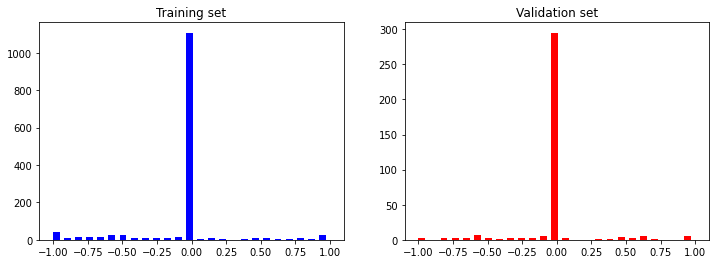

In [ ]:
# The next step was to split the data using the 80–20 rule which means using 80% of the data for training while the rest for testing the model on unseen images. 
# Also, I plotted the sample training and validation steering angle distributions.

X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
# I continued by doing some image processing. I cropped the image to remove the unnecessary features, changes the images to YUV format
# Used gaussian blur, decreased the size for easier processing and normalized the values

def img_preprocess(img):
  img = npimg.imread(img)
  
  ## Crop image to remove unnecessary features
  img = img[60:135, :, :]
  
  ## Change to YUV image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  
  ## Gaussian blur
  img = cv2.GaussianBlur(img, (3, 3), 0)
  
  ## Decrease size for easier processing
  img = cv2.resize(img, (100, 100))
  
  ## Normalize values
  img = img / 255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

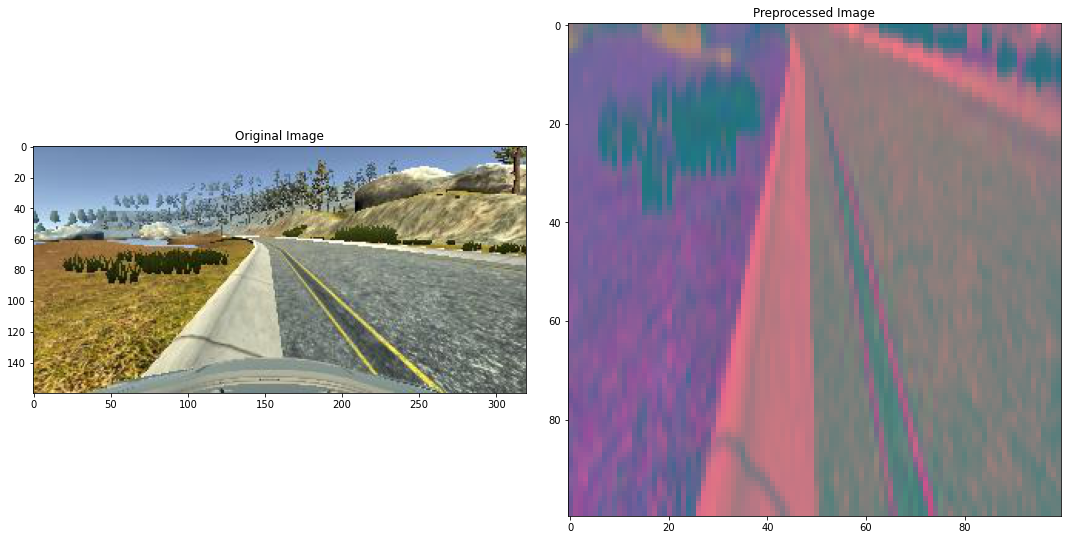

In [ ]:
# To compare and visualize I plotted the original and the pre-processed image

image = image_paths[100]
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [ ]:
# I converted all the images into numpy array

X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

In [ ]:
# I have used ResNet as the pre-trained weights

from keras.applications.resnet import ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in resnet.layers[:-4]:
    layer.trainable = False
 
for layer in resnet.layers:
    print(layer, layer.trainable)

94781440/94765736 [==============================] - 1s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7fb339d92710> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fb33d8f0050> False
<keras.layers.convolutional.Conv2D object at 0x7fb33852c5d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb337cd7390> False
<keras.layers.core.activation.Activation object at 0x7fb33852cc10> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fb33479a710> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb339d859d0> False
<keras.layers.convolutional.Conv2D object at 0x7fb3347c2090> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb3347cc210> False
<keras.layers.core.activation.Activation object at 0x7fb3347cff90> False
<keras.layers.convolutional.Conv2D object at 0x7fb334753d90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb33475c410> False
<keras.

In [ ]:
# I have used three dense layers with 100, 50 and 10 neurons respectively and elu as the activation function
# Also in between, I have used 50% dropouts to reduce over-fitting the values to the training set

def nvidia_model():
  model = Sequential()
  model.add(resnet)
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model

model = nvidia_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout_20 (Dropout)        (None, 4, 4, 2048)        0         
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_20 (Dense)            (None, 100)               3276900   
                                                                 
 dropout_21 (Dropout)        (None, 100)               0         
                                                                 
 dense_21 (Dense)            (None, 50)                5050      
                                                                 
 dropout_22 (Dropout)        (None, 50)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/25
11/11 [==============================] - 47s 4s/step - loss: 63.7393 - accuracy: 0.4261 - val_loss: 0.0822 - val_accuracy: 0.8309
Epoch 2/25
11/11 [==============================] - 44s 4s/step - loss: 8.8251 - accuracy: 0.4692 - val_loss: 0.3116 - val_accuracy: 0.8309
Epoch 3/25
11/11 [==============================] - 43s 4s/step - loss: 5.8179 - accuracy: 0.4541 - val_loss: 0.1090 - val_accuracy: 0.8309
Epoch 4/25
11/11 [==============================] - 43s 4s/step - loss: 5.2275 - accuracy: 0.4433 - val_loss: 0.4791 - val_accuracy: 0.0143
Epoch 5/25
11/11 [==============================] - 42s 4s/step - loss: 4.4812 - accuracy: 0.4735 - val_loss: 0.0623 - val_accuracy: 0.8309
Epoch 6/25
11/11 [==============================] - 44s 4s/step - loss: 4.2469 - accuracy: 0.4692 - val_loss: 0.1931 - val_accuracy: 0.8309
Epoch 7/25
11/11 [==============================] - 43s 4s/step - loss: 3.6852 - accuracy: 0.4778 - val_loss: 0.1588 - val_accuracy: 0.8309
Epoch 8/25
11/11 [=

Text(0.5, 0, 'Epoch')

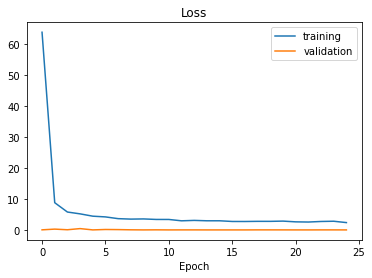

In [ ]:
# I trained the model for 25 epochs with a batch size of 128
# Also, I plotted the training and the validation loss as a function of epochs

history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_valid, Y_valid), batch_size=128, verbose=1, shuffle=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')